The purpose of this notebook is to explore multi-output models, and see in the case of captcha recognition whether its better to have 1 output branche giving 5 predictions for the 5 characters of the captcha, or 5 independant branches each predicting 1 of the 5 characters.

Number of images : 1070
Image dimensions : (50, 200)
Label length : 5


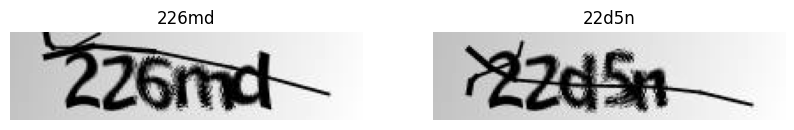

In [129]:
import os
import numpy as np
import cv2
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
from sklearn.utils import shuffle
from tensorflow.keras import models


# Define the folder path
folder_path = 'samples'

#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)
images = []
labels = []

# Load images and labels
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load image
        img = cv2.imread(os.path.join(folder_path, filename))
        # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Append to lists
        images.append(gray_img)
        labels.append(os.path.splitext(filename)[0])

# Display two images with their labels
plt.figure(figsize=(10, 5))

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

print(f"Number of images : {len(images)}")
print(f"Image dimensions : {images[0].shape}")
print(f"Label length : {len(labels[0])}")

plt.show()

# Prepare Data

In [130]:
# Create one-hot encoded matrix for labels
# Each label has 5 characters, and each character can be one of the symbols
label_length = 5
n_samples = len(labels)
one_hot_labels = np.zeros((n_samples, label_length, num_symbols))

# Fill the one-hot encoded matrix
for i, label in enumerate(labels):
    for j, char in enumerate(label):
        char_index = symbols.find(char)
        one_hot_labels[i, j, char_index] = 1

# Verify the shape of the encoded labels
print(f"One-hot encoded labels shape: {one_hot_labels.shape}")
print(f"Possible characters : {list(symbols)}")
print(f"Example of first label '{labels[0]}' encoded:")
for j in range(label_length):
    char_index = np.where(one_hot_labels[0, j] == 1)[0][0]
    print(f"Position {j}: {symbols[char_index]} -> {one_hot_labels[0, j]}")

One-hot encoded labels shape: (1070, 5, 36)
Possible characters : ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Example of first label '226md' encoded:
Position 0: 2 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Position 1: 2 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Position 2: 6 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Position 3: m -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Position 4: d -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [131]:
# Convert list of images to numpy array and normalize
X = np.array(images) / 255.0
X = np.expand_dims(X, axis=-1)  # Add channel dimension

# Reshape y to match the expected format (n_samples, 5, num_symbols)
y = one_hot_labels

# Shuffle the data
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Split ratios (80% train, 10% validation, 10% test)
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

# Split the data
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train label vector shape: {y_train.shape}")
print(f"Validation label vector shape: {y_val.shape}")
print(f"Test label vector shape: {y_test.shape}")

Training set shape: (856, 50, 200, 1)
Validation set shape: (107, 50, 200, 1)
Test set shape: (107, 50, 200, 1)
Train label vector shape: (856, 5, 36)
Validation label vector shape: (107, 5, 36)
Test label vector shape: (107, 5, 36)


# Function to visualize / evaluate models

In [104]:
def evaluate_predictions(model, X_test, y_test, symbols, num_samples=20):
    plt.figure(figsize=(20, 10))
    correct_predictions = 0
    total_chars = num_samples * 5  # 5 characters per sample
    complete_correct = 0

    for i in range(num_samples):
        
        # Get prediction for single image
        pred = model.predict(X_test[i:i+1], verbose=0)
        pred_indices = [np.argmax(pred[0, j]) for j in range(5)]
        pred_text = ''.join([symbols[j] for j in pred_indices])
        
        # Get true label
        true_indices = [np.argmax(y_test[i, j]) for j in range(5)]
        true_text = ''.join([symbols[j] for j in true_indices])
        
        # Count correct characters
        correct_predictions += sum(1 for p, t in zip(pred_text, true_text) if p == t)
        
        # Count correct captcha completions
        if pred_text == true_text:
            complete_correct += 1            
        
        # Display result
        plt.subplot(4, 5, i+1)
        plt.imshow(X_test[i].squeeze(), cmap='gray')
        plt.title(f"Pred : {pred_text}", 
                 color='green' if pred_text == true_text else 'red',
                 fontsize=10)
        plt.axis('off')

    # Show accuracy
    accuracy = correct_predictions / total_chars
    print(f"Character-level accuracy: {accuracy:.2%}")
    completion_rate = complete_correct / num_samples
    print(f"Complete captcha success rate: {completion_rate:.2%}")
    plt.tight_layout()
    plt.show()

In [105]:
def evaluate_predictions_multi_output(model, X_test, y_test, symbols, num_samples=20):
    plt.figure(figsize=(20, 10))
    correct_predictions = 0
    total_chars = num_samples * 5  # 5 characters per sample
    complete_correct = 0

    for i in range(num_samples):
        # Get predictions for single image
        preds = model.predict(X_test[i:i+1], verbose=0)  # Returns list of 5 predictions
        
        # Get predicted indices for each character
        pred_indices = [np.argmax(preds[j][0]) for j in range(5)]
        pred_text = ''.join([symbols[j] for j in pred_indices])
        
        # Get true labels
        true_indices = [np.argmax(y_test[j, i]) for j in range(5)]  # Changed indexing order
        true_text = ''.join([symbols[j] for j in true_indices])
        
        # Count correct characters
        correct_predictions += sum(1 for p, t in zip(pred_text, true_text) if p == t)
        
        # Count complete correct predictions
        if pred_text == true_text:
            complete_correct += 1
        
        # Display result
        plt.subplot(4, 5, i+1)
        plt.imshow(X_test[i].squeeze(), cmap='gray')
        plt.title(f"True: {true_text}\nPred: {pred_text}", 
                 color='green' if pred_text == true_text else 'red',
                 fontsize=10)
        plt.axis('off')

    # Show accuracy metrics
    accuracy = correct_predictions / total_chars
    print(f"Character-level accuracy: {accuracy:.2%}")
    completion_rate = complete_correct / num_samples
    print(f"Complete captcha success rate: {completion_rate:.2%}")
    plt.tight_layout()
    plt.show()

___

In [110]:
nb_epoch = 25
batch_size = 16

# Predicting 5 chars at once

# CNN

In [111]:
# Define the model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 200, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5 * 36, activation='softmax'),  # 5 characters, 36 possible classes (A-Z, 0-9)
    layers.Reshape((5, 36))  # Reshape to (sequence_length, num_classes)
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
cnn_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 48, 198, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 33792)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 128)            │     4,325,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 180)            │        23,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_17 (Reshape)            │ (None, 5, 36)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,367,540 (16.66 MB)

 Trainable params: 4,367,540 (16.66 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
# Train the model
history = cnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, y_val))

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.0647 - loss: 3.4036 - val_accuracy: 0.1626 - val_loss: 2.8758
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2152 - loss: 2.6316 - val_accuracy: 0.3458 - val_loss: 2.1528
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4527 - loss: 1.8040 - val_accuracy: 0.4505 - val_loss: 1.7614
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6199 - loss: 1.2175 - val_accuracy: 0.5327 - val_loss: 1.5382
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7590 - loss: 0.7968 - val_accuracy: 0.5776 - val_loss: 1.4547
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8374 - loss: 0.5374 - val_accuracy: 0.5813 - val_loss: 1.5383
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8656 - loss: 0.4247 - val_accuracy: 0.5869 - val_loss: 1.6149
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9207 - loss: 0.2471 - val_accuracy: 0.6150 - v

Character-level accuracy: 71.00%
Complete captcha success rate: 20.00%


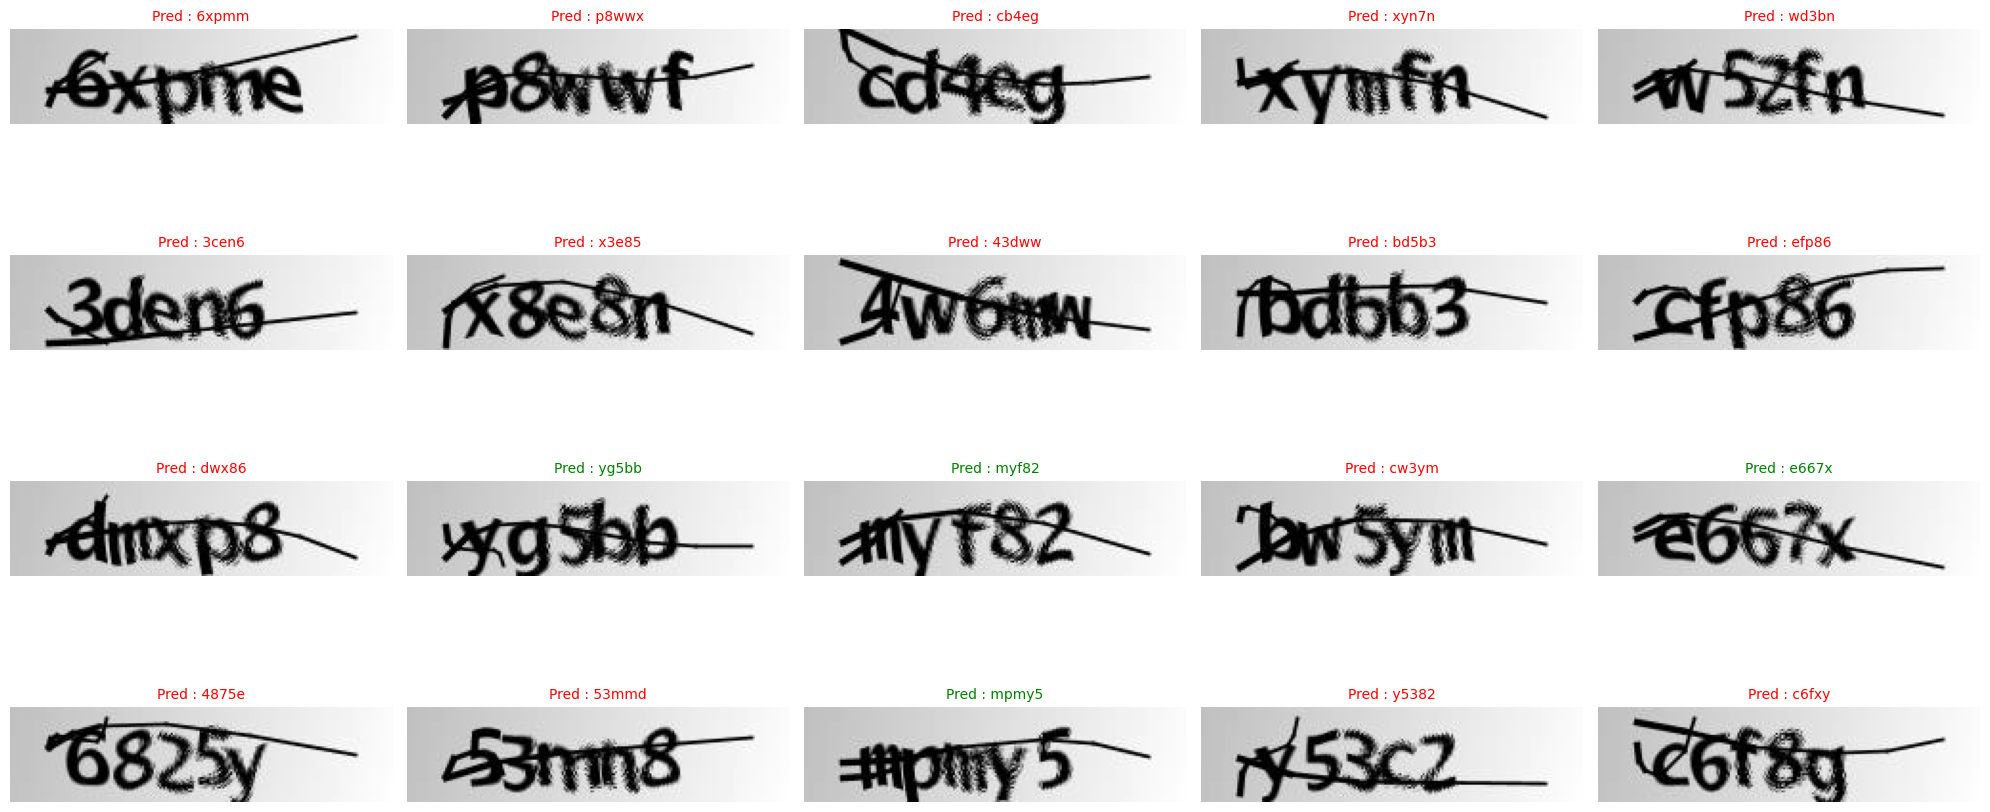

In [113]:
# Evaluate CNN model
evaluate_predictions(cnn_model, X_test, y_test, symbols)

# CNN LSTM

In [61]:
# Define the model
cnn_lstm_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 200, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.TimeDistributed(layers.Flatten()),  # Flatten each time step
    layers.LSTM(128, return_sequences=True),  # LSTM layer
    layers.TimeDistributed(layers.Dense(36, activation='softmax')),  # 36 possible classes (A-Z, 0-9)
    layers.Lambda(lambda x: x[:, :5, :])  # Ensure output has exactly 5 timesteps
])

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
cnn_lstm_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 48, 198, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 11, 3072)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 11, 128)        │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 11, 36)         │         4,644 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 5, 36)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,372 (6.34 MB)

 Trainable params: 1,662,372 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_lstm_model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, y_val))

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.0836 - loss: 3.1965 - val_accuracy: 0.1047 - val_loss: 2.9478
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.0979 - loss: 2.9425 - val_accuracy: 0.1047 - val_loss: 2.9379
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.0976 - loss: 2.9400 - val_accuracy: 0.1047 - val_loss: 2.9136
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.1002 - loss: 2.9013 - val_accuracy: 0.1121 - val_loss: 2.8620
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.1324 - loss: 2.8098 - val_accuracy: 0.1495 - val_loss: 2.7833
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.1652 - loss: 2.7020 - val_accuracy: 0.1551 - val_loss: 2.7101
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.1954 - loss: 2.5824 - val_accuracy: 0.1664 - val_loss: 2.6339
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.2410 - loss: 2.4706 - val_accuracy: 0.2037 - v

Character-level accuracy: 21.00%
Complete captcha success rate: 0.00%


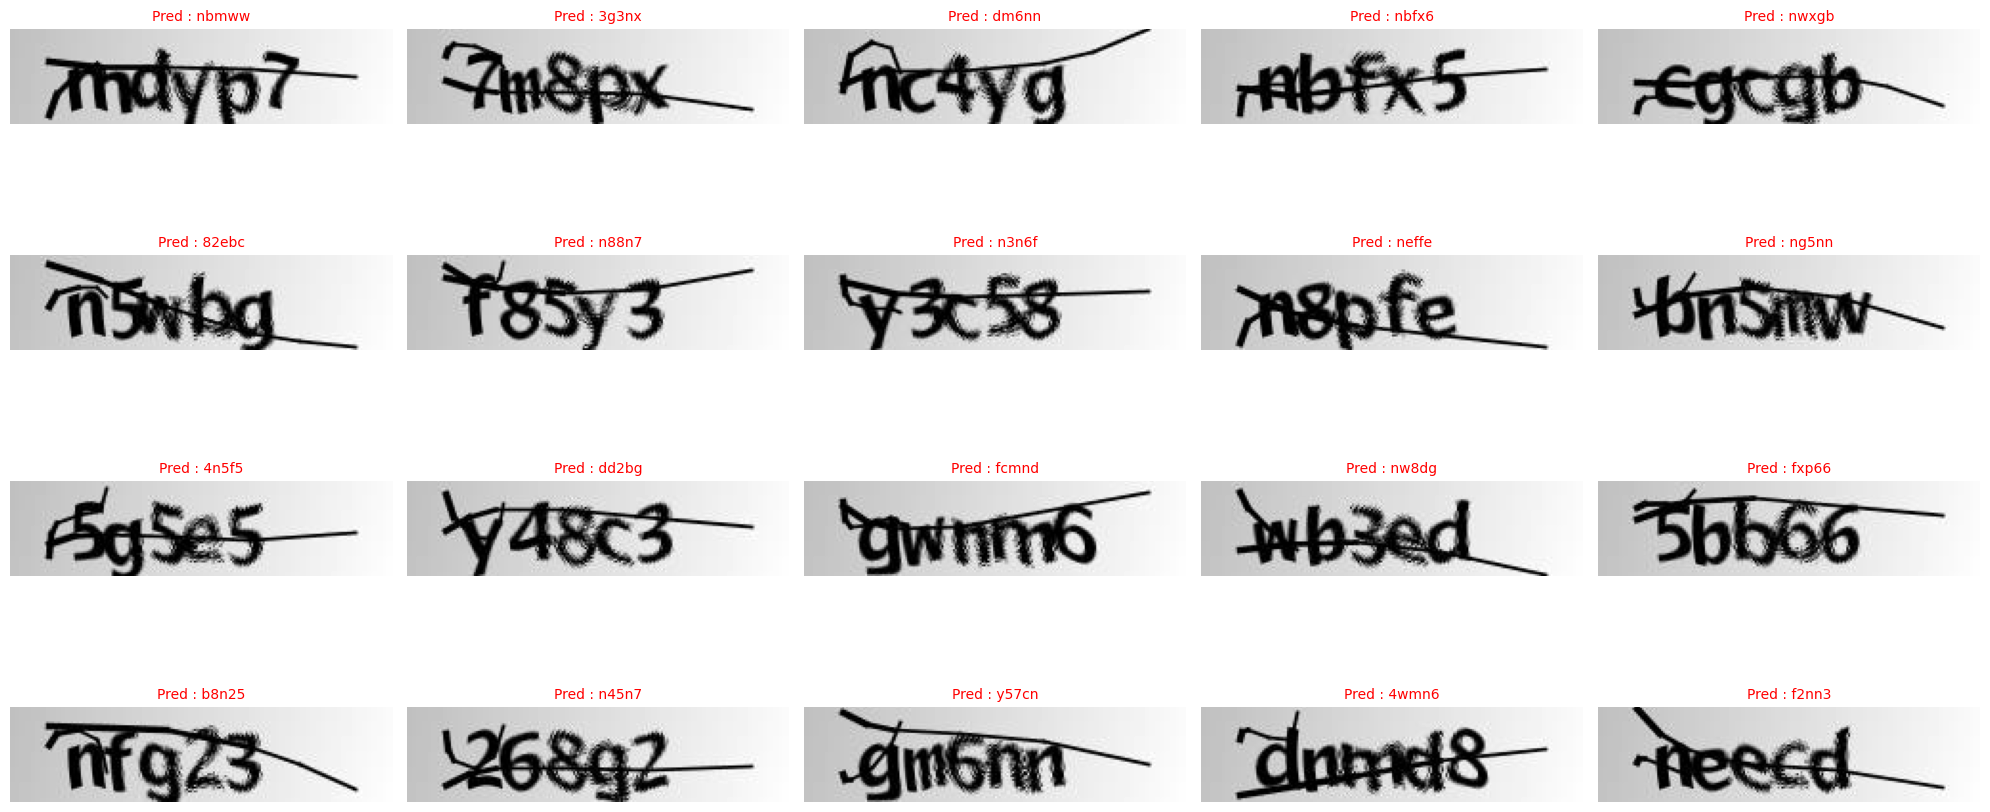

In [63]:
# Evaluate CNN+LSTM model
evaluate_predictions(cnn_lstm_model, X_test, y_test, symbols)

# CRNN

In [66]:
# Define the model
crnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 200, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Reshape((-1, 64)),  # Reshape for RNN
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),  # Bidirectional LSTM
    layers.TimeDistributed(layers.Dense(36, activation='softmax')),  # 36 possible classes (A-Z, 0-9)
    layers.Lambda(lambda x: x[:, :5, :])  # Ensure output has exactly 5 timesteps
])

# Compile the model
crnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
crnn_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 48, 198, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 528, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 528, 256)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 528, 36)        │         9,252 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 5, 36)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,700 (881.64 KB)

 Trainable params: 225,700 (881.64 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
#crnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, y_val))

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.0833 - loss: 3.3243 - val_accuracy: 0.1047 - val_loss: 2.9298
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.0832 - loss: 2.9592 - val_accuracy: 0.1047 - val_loss: 2.9401
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.0814 - loss: 2.9535 - val_accuracy: 0.1047 - val_loss: 2.9329
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.0919 - loss: 2.9438 - val_accuracy: 0.1047 - val_loss: 2.9290
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.0958 - loss: 2.9366 - val_accuracy: 0.1047 - val_loss: 2.9358
Epoch 6/20
 5/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0795 - loss: 2.9517

KeyboardInterrupt: 

In [ ]:
# Evaluate CRNN model
# evaluate_predictions(crnn_model, X_test, y_test, symbols)

# Transformer

In [68]:
# Define the Transformer encoder layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):  # Add `training` argument with a default value
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the model
inputs = layers.Input(shape=(50, 200, 1))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Reshape((-1, 64))(x)  # Reshape for Transformer
x = TransformerEncoder(embed_dim=64, num_heads=4, ff_dim=128)(x, training=False)  # Pass `training=False` during inference
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5 * 36, activation='softmax')(x)  # 5 characters, 36 classes
outputs = layers.Reshape((5, 36))(outputs)

transformer_model = models.Model(inputs, outputs)

# Compile the model
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
transformer_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 50, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 48, 198, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 528, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 528, 64)        │        83,200 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 180)            │        11,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 5, 36)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,716 (444.20 KB)

 Trainable params: 113,716 (444.20 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
# Define the Transformer Encoder Layer
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the model
def build_transformer_model(input_shape, num_classes, num_heads, ff_dim, num_transformer_blocks):
    inputs = layers.Input(shape=input_shape)
    
    # CNN layers
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.TimeDistributed(layers.Flatten())(x)
    
    # Transformer Encoder layers
    embed_dim = x.shape[-1]
    for _ in range(num_transformer_blocks):
        x = TransformerEncoderLayer(embed_dim, num_heads, ff_dim)(x, training=False)
    
    # Final Dense layer
    x = layers.TimeDistributed(layers.Dense(num_classes, activation='softmax'))(x)
    x = layers.Lambda(lambda x: x[:, :5, :])(x)  # Ensure output has exactly 5 timesteps
    
    model = models.Model(inputs, x)
    return model

# Model parameters
input_shape = (50, 200, 1)
num_classes = 36
num_heads = 5
ff_dim = 128
num_transformer_blocks = 2

# Build the model
transformer_model = build_transformer_model(input_shape, num_classes, num_heads, ff_dim, num_transformer_blocks)

# Compile the model
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
transformer_model.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 50, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 48, 198, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 11, 3072)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_layer_3     │ (None, 11, 3072)       │   189,594,752 │
│ (TransformerEncoderLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_layer_4     │ (None, 11, 3072)       │   189,594,752 │
│ (TransformerEncoderLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 11, 36)         │       110,628 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 5, 36)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,318,948 (1.41 GB)

 Trainable params: 379,318,948 (1.41 GB)

 Non-trainable params: 0 (0.00 B)

Character-level accuracy: 11.00%
Complete captcha success rate: 0.00%


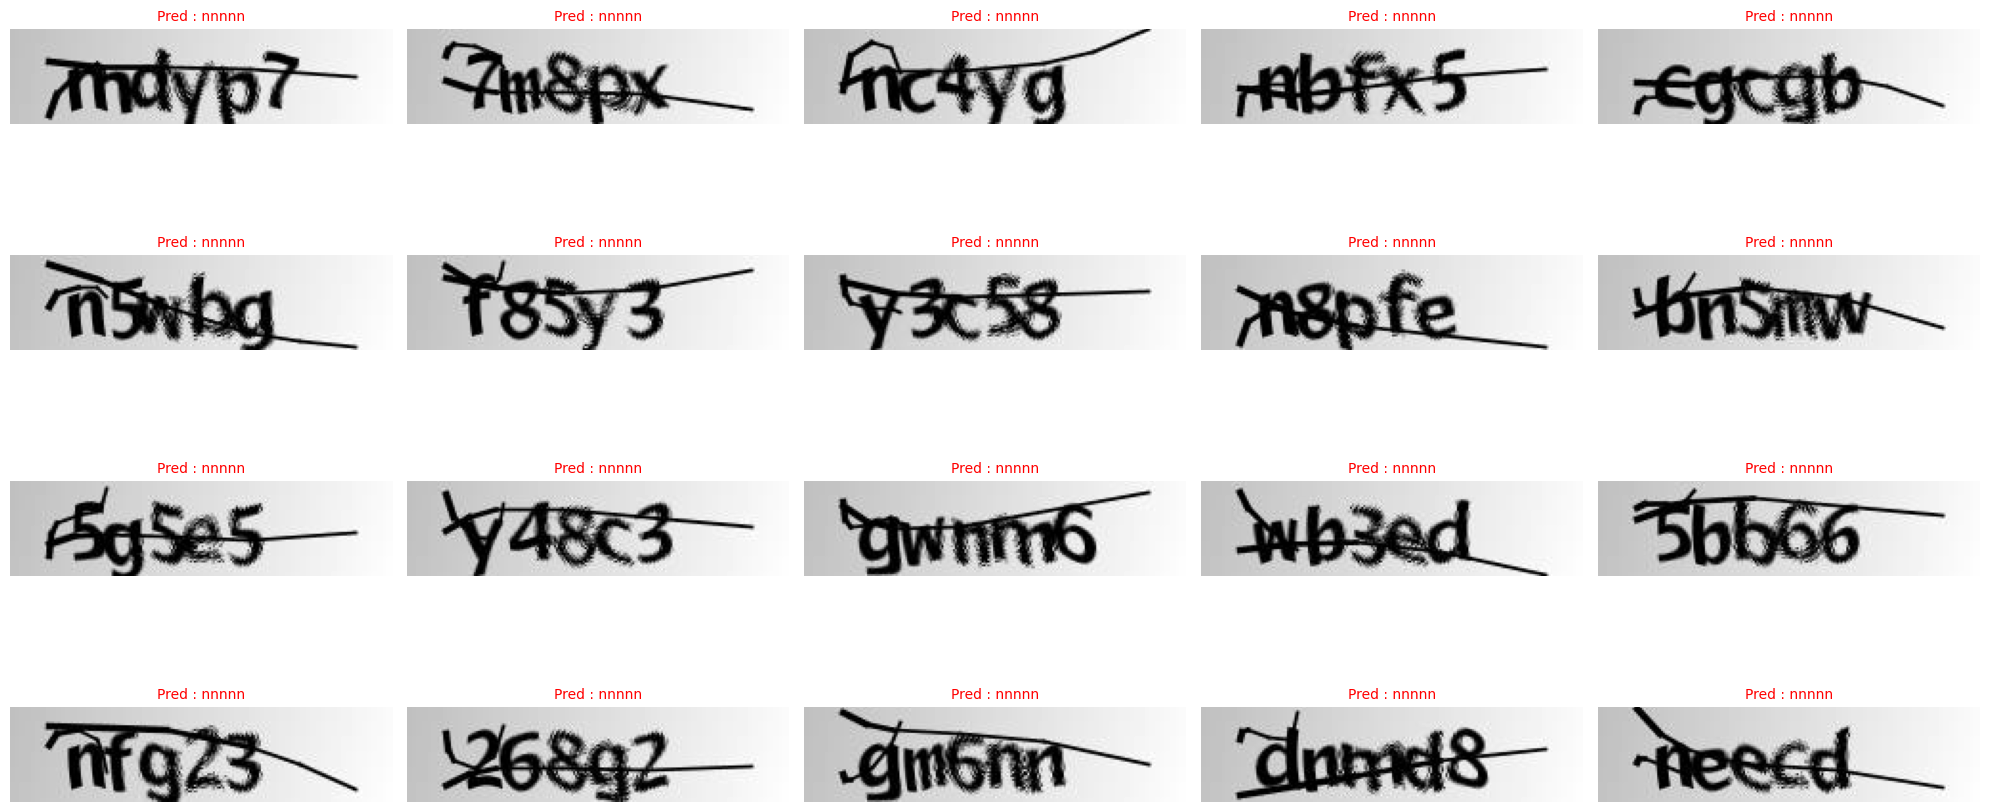

In [70]:
# Evaluate Transformer model
evaluate_predictions(transformer_model, X_test, y_test, symbols)

# CNN with Attention

In [72]:
# Define the attention layer
class AttentionLayer(layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, self.W), axis=1)  # Shape: (batch_size, timesteps, 1)
        weighted_inputs = inputs * attention_weights  # Shape: (batch_size, timesteps, features)
        return tf.reduce_sum(weighted_inputs, axis=1)  # Shape: (batch_size, features)

# Define the model
inputs = layers.Input(shape=(50, 200, 1))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)  # Shape: (batch_size, flattened_features)
x = layers.Reshape((-1, 64))(x)  # Reshape to (batch_size, timesteps, features)
x = AttentionLayer()(x)  # Shape: (batch_size, features)
outputs = layers.Dense(5 * 36, activation='softmax')(x)  # 5 characters, 36 classes
outputs = layers.Reshape((5, 36))(outputs)  # Shape: (batch_size, 5, 36)

cnn_attention_model = models.Model(inputs, outputs)

# Compile the model
cnn_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
cnn_attention_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 50, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 48, 198, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 33792)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 528, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_2               │ (None, 64)             │            64 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 180)            │        11,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 5, 36)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,580 (119.45 KB)

 Trainable params: 30,580 (119.45 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
cnn_attention_model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, y_val))

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.0456 - loss: 3.5205 - val_accuracy: 0.0505 - val_loss: 3.1934
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0743 - loss: 3.1013 - val_accuracy: 0.1009 - val_loss: 2.9586
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0992 - loss: 2.9492 - val_accuracy: 0.1047 - val_loss: 2.9331
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1006 - loss: 2.9421 - val_accuracy: 0.1047 - val_loss: 2.9439
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0955 - loss: 2.9369 - val_accuracy: 0.0841 - val_loss: 2.9423
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0987 - loss: 2.9335 - val_accuracy: 0.1047 - val_loss: 2.9355
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0966 - loss: 2.9339 - val_accuracy: 0.1047 - val_loss: 2.9362
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0971 - loss: 2.9321 - val_accuracy: 0.1047 - v

IndexError: index 5 is out of bounds for axis 0 with size 5

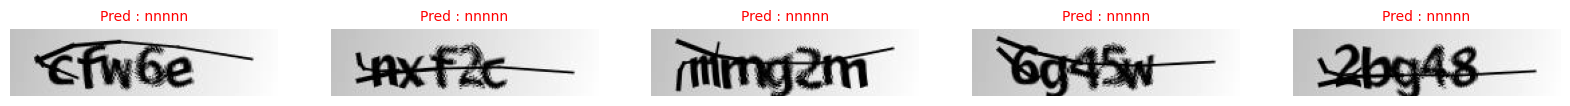

In [75]:
# Evaluate CNN with Attention model
evaluate_predictions(cnn_attention_model, X_test, y_test, symbols)

___

# Models with 5 branches to predict the 5 characters

# Prepare data

In [114]:
def preprocess_data():
    n_samples = len(os.listdir(folder_path))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir(folder_path)):
        # Read image as grayscale
        img = cv2.imread(os.path.join(folder_path, pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            if img is not None:
                img = img / 255.0
                img = np.reshape(img, (50, 200, 1))
                # Define targets and code them using OneHotEncoding
                targs = np.zeros((5, num_symbols))
                for j, l in enumerate(pic_target):
                    ind = symbols.find(l)
                    targs[j, ind] = 1
                X[i] = img
                y[:, i] = targs
    
    # Shuffle the data
    X, y = shuffle(X, y.transpose(1, 0, 2), random_state=42)
    y = y.transpose(1, 0, 2)
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_val, y_val = X[970:1050], y[:, 970:1050]
X_test, y_test = X[1050:], y[:, 1050:]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train label vector shape: {y_train.shape}")
print(f"Validation label vector shape: {y_val.shape}")
print(f"Test label vector length: {y_test.shape}")

Training set shape: (970, 50, 200, 1)
Validation set shape: (80, 50, 200, 1)
Test set shape: (20, 50, 200, 1)
Train label vector shape: (5, 970, 36)
Validation label vector shape: (5, 80, 36)
Test label vector length: (5, 20, 36)


In [115]:
def create_model(img_shape=(50, 200, 1), num_symbols=36):
    # Input layer
    img = layers.Input(shape=img_shape)  # Input image

    # Convolutional backbone
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # Output shape: (25, 100, 16)
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # Output shape: (13, 50, 32)
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # Output shape: (7, 25, 32)

    # Flatten the output
    flat = layers.Flatten()(mp3)  # Flatten to 1D vector

    # Create 5 branches for character prediction
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)  # Fully connected layer
        drop = layers.Dropout(0.5)(dens1)  # Dropout for regularization
        res = layers.Dense(num_symbols, activation='softmax')(drop)  # Character prediction
        outs.append(res)

    # Define the model
    model = models.Model(img, outs)

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',  # Loss for each branch
        optimizer='adam',  # Optimizer
        metrics=5*['accuracy']  # Accuracy for each branch
    )

    return model

# Create the model
model = create_model()
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 50, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 50, 200,   │        160 │ input_layer_26[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_51    │ (None, 25, 100,   │          0 │ conv2d_51[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 25, 100,   │      4,640 │ max_pooling2d_51… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_52    │ (None, 13, 50,    │          0 │ conv2d_52[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 13, 50,    │      9,248 │ max_pooling2d_52… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 50,    │        128 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_53    │ (None, 7, 25, 32) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 5600)      │          0 │ max_pooling2d_53… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 64)        │    358,464 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 64)        │    358,464 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_75 (Dense)    │ (None, 64)        │    358,464 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_77 (Dense)    │ (None, 64)        │    358,464 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 64)        │    358,464 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 64)        │          0 │ dense_71[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 64)        │          0 │ dense_73[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 64)        │          0 │ dense_75[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64)        │          0 │ dense_77[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,818,196 (6.94 MB)

 Trainable params: 1,818,132 (6.94 MB)

 Non-trainable params: 64 (256.00 B)

In [116]:
# Train the model
history = model.fit(
    X_train, [y_train[i, :, :] for i in range(5)],
    validation_data=(X_val, [y_val[i, :, :] for i in range(5)]),
    epochs=nb_epoch,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - dense_72_accuracy: 0.0520 - dense_72_loss: 3.5641 - dense_74_accuracy: 0.0501 - dense_74_loss: 3.6253 - dense_76_accuracy: 0.0514 - dense_76_loss: 3.6504 - dense_78_accuracy: 0.0403 - dense_78_loss: 3.5890 - dense_80_accuracy: 0.0501 - dense_80_loss: 3.5657 - loss: 17.9946 - val_dense_72_accuracy: 0.1250 - val_dense_72_loss: 3.5222 - val_dense_74_accuracy: 0.1500 - val_dense_74_loss: 3.5177 - val_dense_76_accuracy: 0.0250 - val_dense_76_loss: 3.5323 - val_dense_78_accuracy: 0.0500 - val_dense_78_loss: 3.5288 - val_dense_80_accuracy: 0.0625 - val_dense_80_loss: 3.5359 - val_loss: 17.6368
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - dense_72_accuracy: 0.1483 - dense_72_loss: 2.9452 - dense_74_accuracy: 0.1370 - dense_74_loss: 2.9694 - dense_76_accuracy: 0.1256 - dense_76_loss: 3.1101 - dense_78_accuracy: 0.0843 - dense_78_loss: 3.1822 - dense_80_accuracy: 0.1196 - dense_80_loss: 3.1280 - loss: 15.3353 - val_dense_72_accuracy: 0

Character-level accuracy: 88.00%
Complete captcha success rate: 55.00%


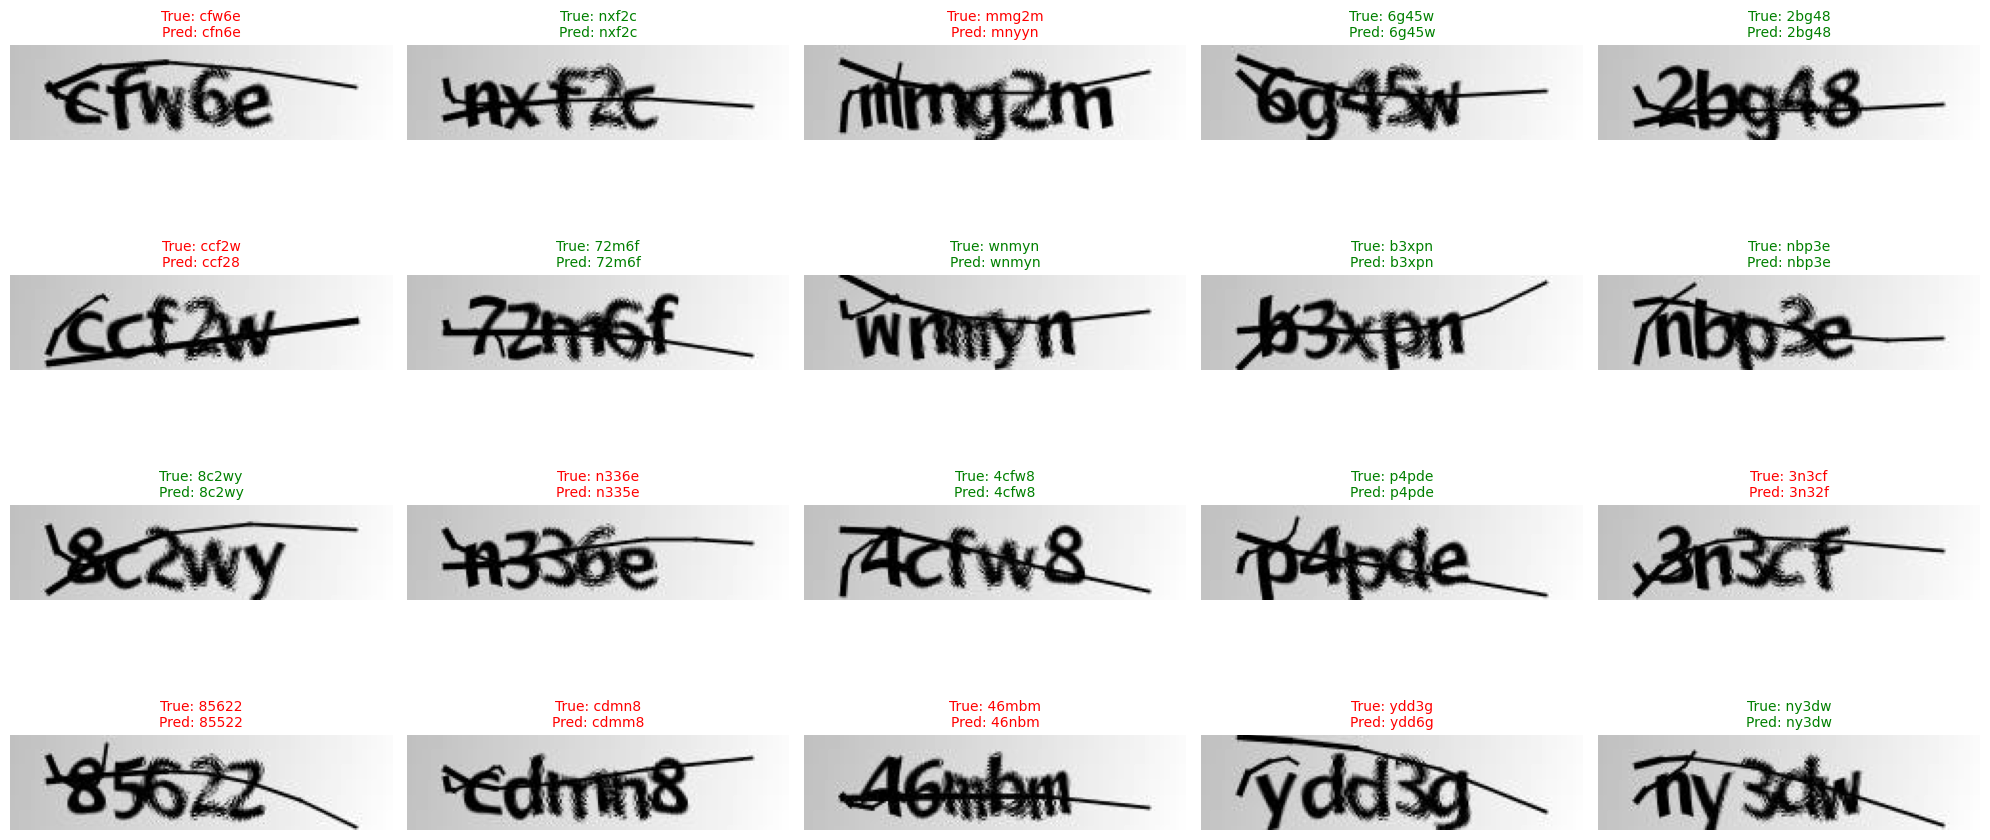

In [117]:
# Evaluate the model
evaluate_predictions_multi_output(model, X_test, y_test, symbols)

Let's try to improve the results

In [118]:
def create_model(img_shape=(50, 200, 1), num_symbols=36):
    # Input layer
    img = layers.Input(shape=img_shape)  # Input image

    # Enhanced Convolutional backbone
    conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # Output shape: (25, 100, 32)
    conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # Output shape: (13, 50, 64)
    conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # Output shape: (7, 25, 128)

    # Flatten the output
    flat = layers.Flatten()(mp3)  # Flatten to 1D vector

    # Shared dense layer for feature extraction
    shared_dense = layers.Dense(256, activation='relu')(flat)
    shared_dropout = layers.Dropout(0.5)(shared_dense)

    # Create 5 branches for character prediction
    outs = []
    for _ in range(5):
        branch_dense = layers.Dense(128, activation='relu')(shared_dropout)  # Branch-specific layer
        branch_dropout = layers.Dropout(0.5)(branch_dense)  # Dropout for regularization
        res = layers.Dense(num_symbols, activation='softmax')(branch_dropout)  # Character prediction
        outs.append(res)

    # Define the model1
    model1 = models.Model(img, outs)

    # Compile the model1
    model1.compile(
        loss='categorical_crossentropy',  # Loss for each branch
        optimizer='adam',  # Optimizer
        metrics=5*['accuracy']  # Accuracy for each branch
    )

    return model1

# Create the model1
model1 = create_model()
model1.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 50, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 50, 200,   │        320 │ input_layer_27[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_54    │ (None, 25, 100,   │          0 │ conv2d_54[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 25, 100,   │     18,496 │ max_pooling2d_54… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_55    │ (None, 13, 50,    │          0 │ conv2d_55[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 13, 50,    │     73,856 │ max_pooling2d_55… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 50,    │        512 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_56    │ (None, 7, 25,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 22400)     │          0 │ max_pooling2d_56… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 256)       │  5,734,656 │ flatten_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 256)       │          0 │ dense_81[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 128)       │     32,896 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 128)       │     32,896 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 128)       │     32,896 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_88 (Dense)    │ (None, 128)       │     32,896 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 128)       │     32,896 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 128)       │          0 │ dense_82[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 128)       │          0 │ dense_84[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 128)       │          0 │ dense_86[0][0]  

 Total params: 6,015,540 (22.95 MB)

 Trainable params: 6,015,284 (22.95 MB)

 Non-trainable params: 256 (1.00 KB)

In [119]:
model1.fit(
    X_train, [y_train[i, :, :] for i in range(5)],
    validation_data=(X_val, [y_val[i, :, :] for i in range(5)]),
    epochs=nb_epoch,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - dense_83_accuracy: 0.0352 - dense_83_loss: 4.2038 - dense_85_accuracy: 0.0546 - dense_85_loss: 4.2061 - dense_87_accuracy: 0.0552 - dense_87_loss: 4.0546 - dense_89_accuracy: 0.0484 - dense_89_loss: 4.1945 - dense_91_accuracy: 0.0483 - dense_91_loss: 3.9741 - loss: 20.6335 - val_dense_83_accuracy: 0.0250 - val_dense_83_loss: 3.4938 - val_dense_85_accuracy: 0.0625 - val_dense_85_loss: 3.4825 - val_dense_87_accuracy: 0.1125 - val_dense_87_loss: 3.4635 - val_dense_89_accuracy: 0.1000 - val_dense_89_loss: 3.4618 - val_dense_91_accuracy: 0.1500 - val_dense_91_loss: 3.4622 - val_loss: 17.3637
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - dense_83_accuracy: 0.0458 - dense_83_loss: 3.3213 - dense_85_accuracy: 0.0792 - dense_85_loss: 3.3144 - dense_87_accuracy: 0.0792 - dense_87_loss: 3.2986 - dense_89_accuracy: 0.0902 - dense_89_loss: 3.2319 - dense_91_accuracy: 0.0644 - dense_91_loss: 3.2515 - loss: 16.4176 - val_dense_83_accuracy: 

Character-level accuracy: 79.00%
Complete captcha success rate: 30.00%


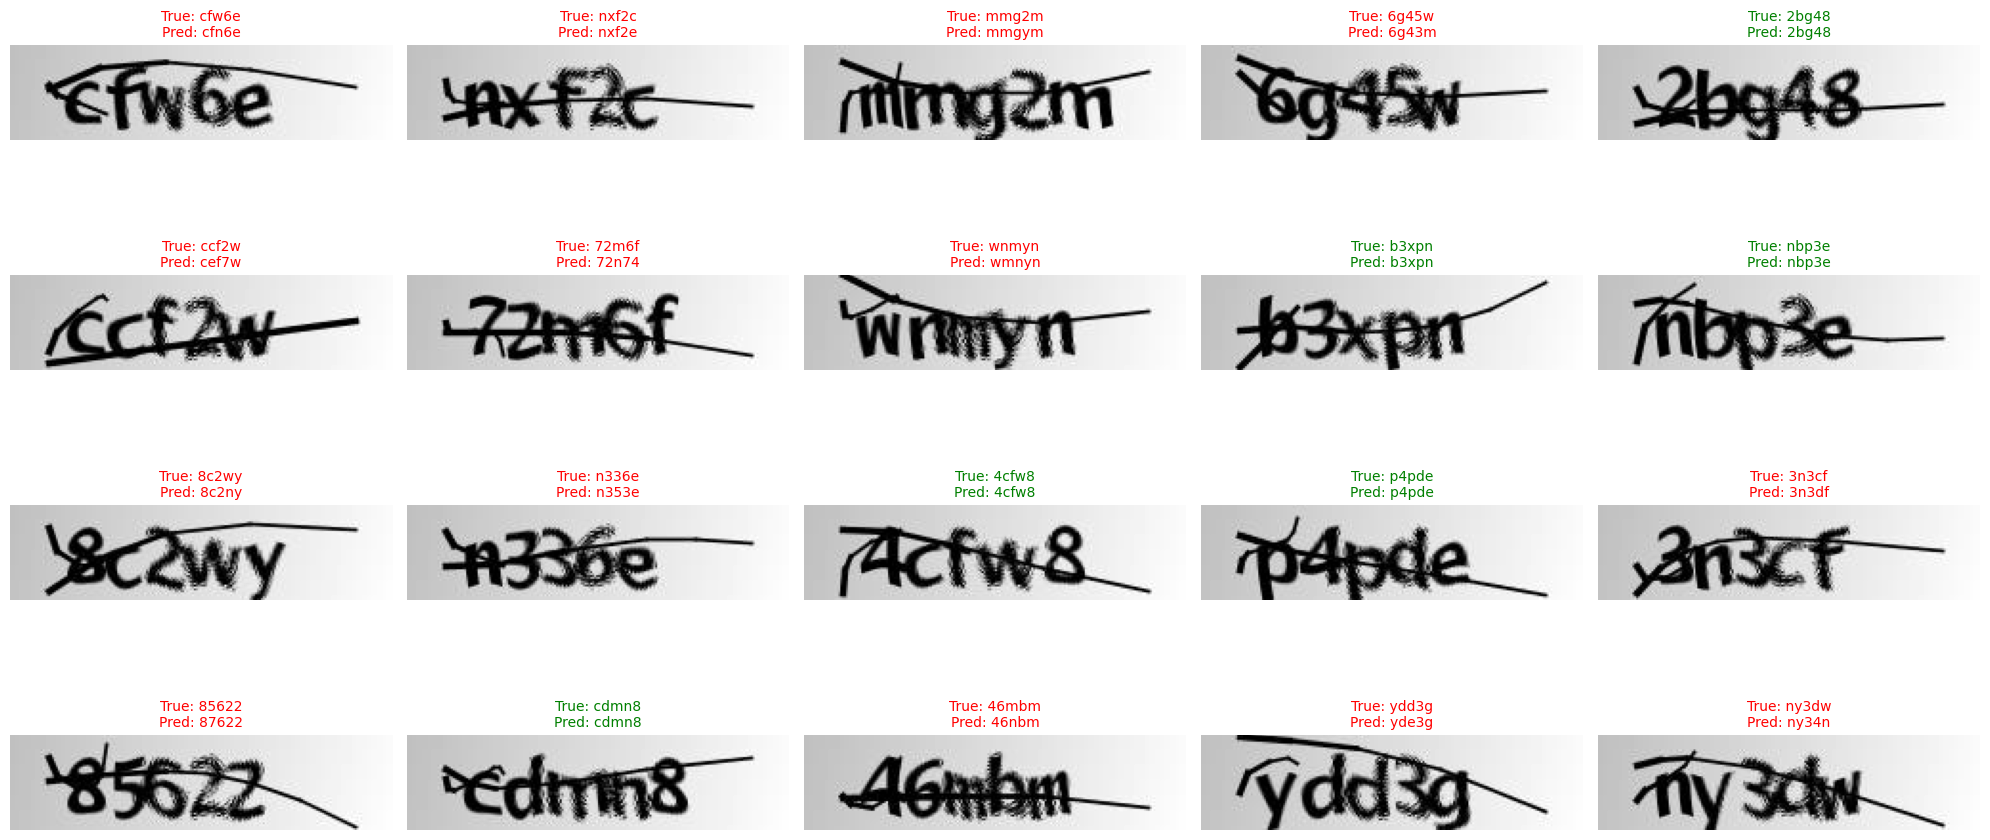

In [120]:
evaluate_predictions_multi_output(model1, X_test, y_test, symbols)

___